In [1]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [41]:

import cv2
import numpy as np
import glob
import os
def calibrate(dirpath, n_max_valid=30, plot=False):
    # Calibrate the Camera
    # number of inside corners in x & y directions
    nx = 9 
    ny = 6
    # prepare object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # Make a list of calibration images
    images = glob.glob(os.path.join(dirpath,"*.jpg"))

    plt.figure(figsize = (18,12))
    grid = gridspec.GridSpec(5,4)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.15)  
    N_MAX_VALID  = n_max_valid
    VALID_CNT = 0
    items = []
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add to object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            items.append((img,corners) )
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            if plot:
                write_name = 'corners_found'+str(VALID_CNT)+'.jpg'
                #cv2.imwrite(write_name,img)
                img_plt = plt.subplot(grid[VALID_CNT])
                plt.axis('on')
                img_plt.set_xticklabels([])
                img_plt.set_yticklabels([])
                #img_plt.set_aspect('equal')
                plt.imshow(img[:,:,::-1])
                plt.title(write_name)
                plt.axis('off')
            VALID_CNT += 1
        if VALID_CNT >= N_MAX_VALID:
            break
    if plot:
        plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs, objpoints,imgpoints, items ]
ret, mtx, dist, rvecs, tvecs, objpoints,imgpoints, items = calibrate('calib_images', n_max_valid=30) 

<Figure size 1296x864 with 0 Axes>

In [42]:
    img = cv2.imread('./calib_images/100.jpg')[:,:,::-1]
    h,w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0, (w, h))

    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]

    cv2.imshow('undist', dst)
    cv2.waitKey(800)

99

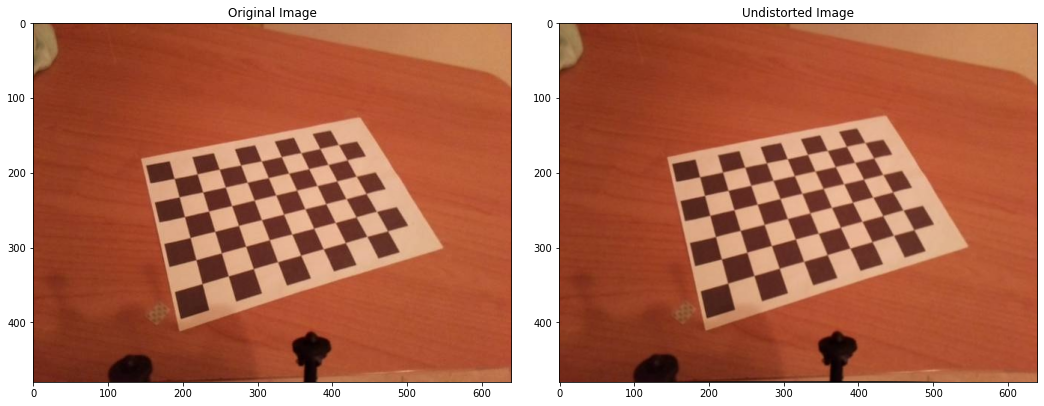

In [60]:
# Take an image, object points, image points, and perform the camera calibration. Undistort the image after camera calibration
        
#load image for reference
image = cv2.imread('./calib_images/500.jpg')[:,:,::-1]
h,w = image.shape[:2]

# Save the camera calibration results for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./params/calibration_pickle.p", "wb"))

#Visualize the before/after distortion on chessboard images
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0, (w, h))
dst = cv2.undistort(image, mtx, dist, None, newcameramtx)
#undist = cv2.undistort(image, mtx, dist, None, mtx)
x,y,w,h = roi
undist = dst[y:y+h, x:x+w]

#cv2.imshow('undist', dst)


plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

img_plt = plt.subplot(grid[0])
plt.imshow(image)
plt.title('Original Image')

img_plt = plt.subplot(grid[1])
plt.imshow(dst)#undist)
plt.title('Undistorted Image')

plt.show()

In [63]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

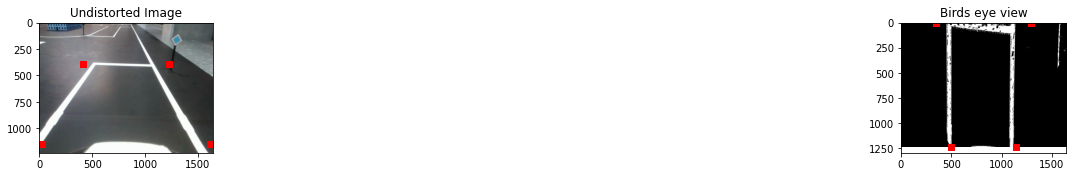

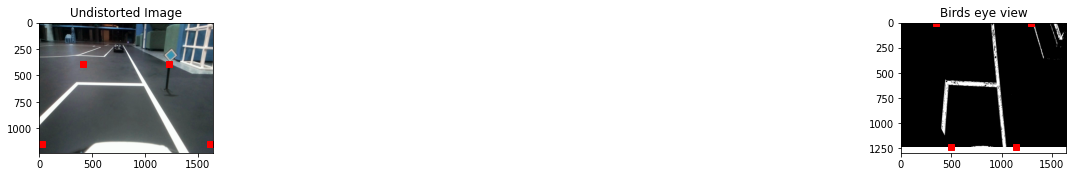

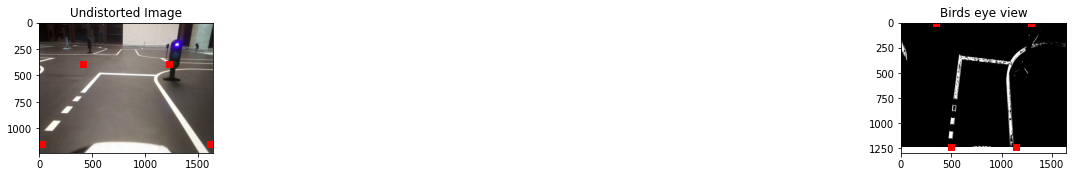

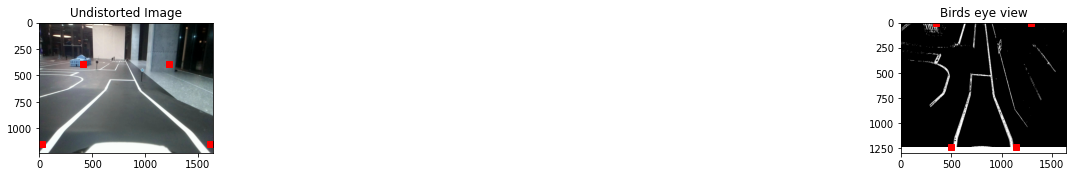

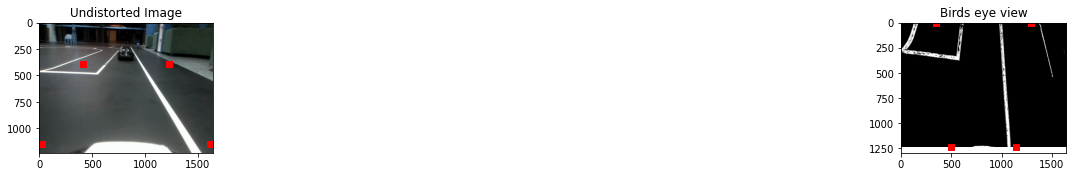

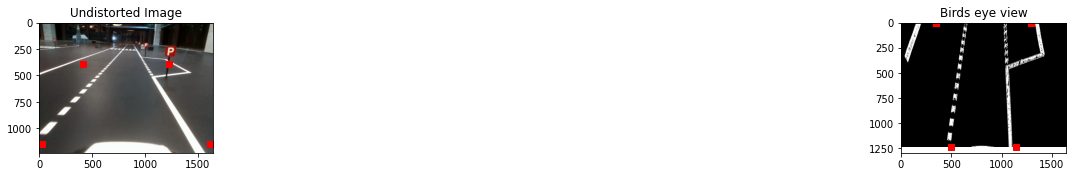

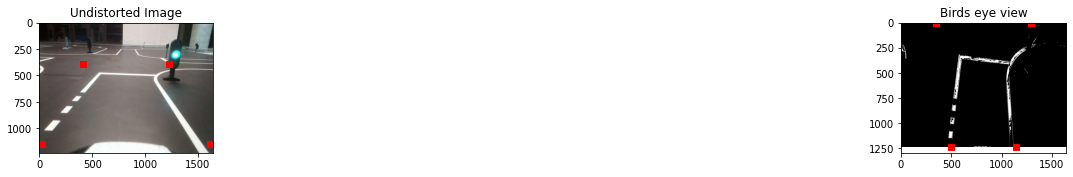

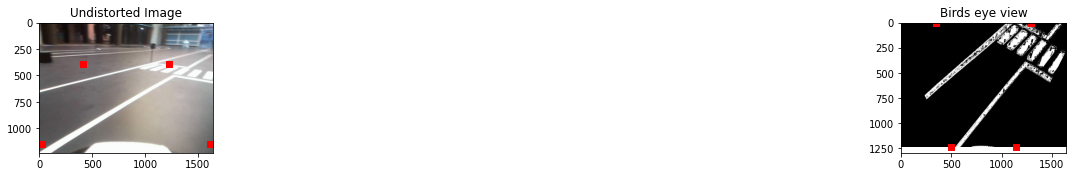

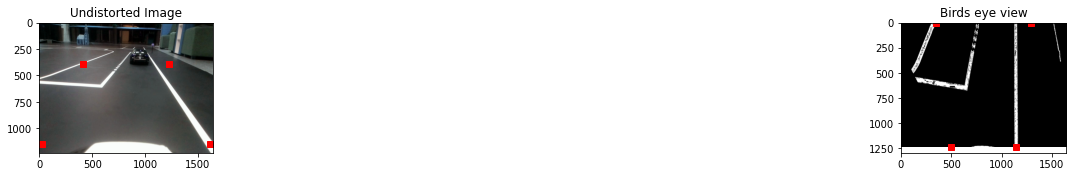

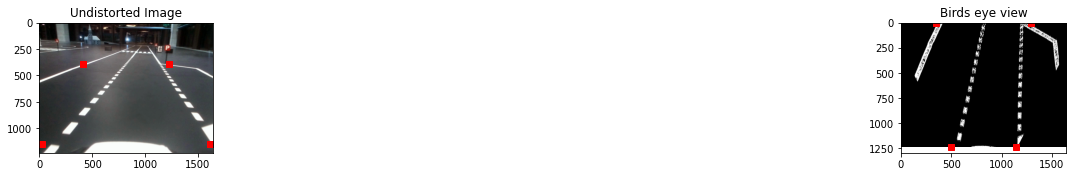

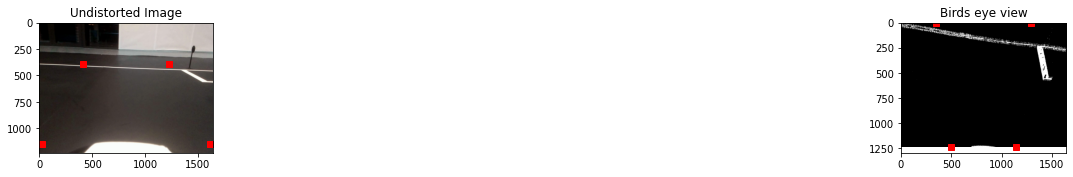

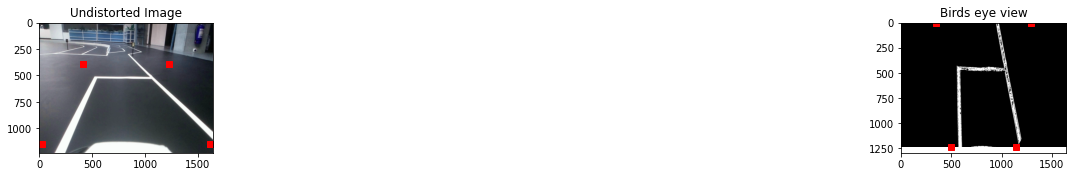

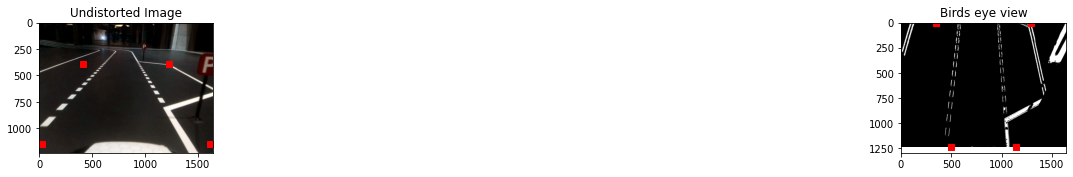

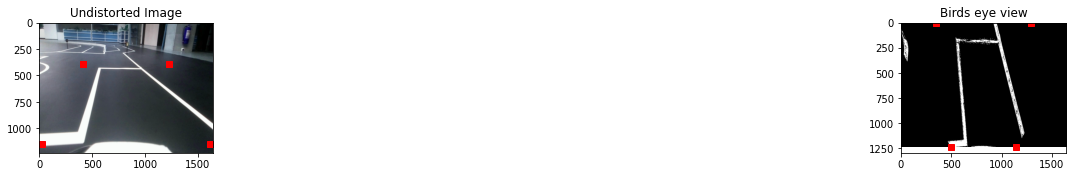

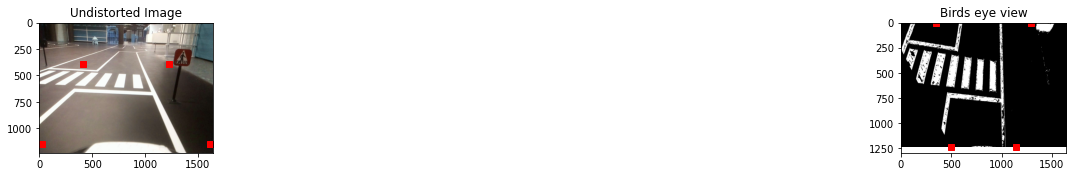

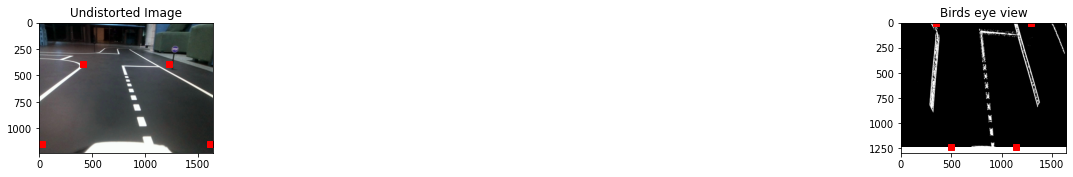

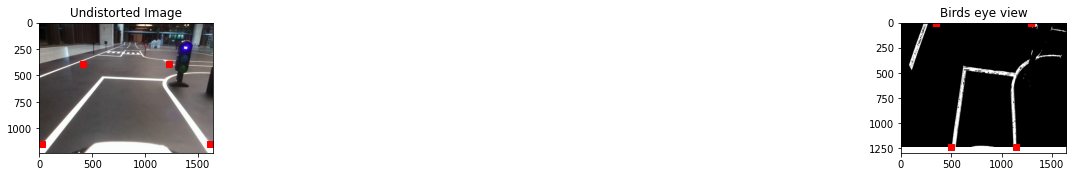

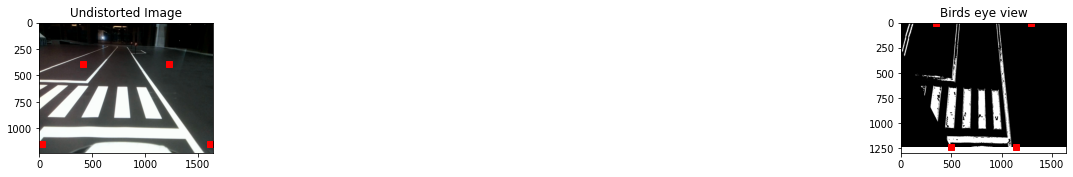

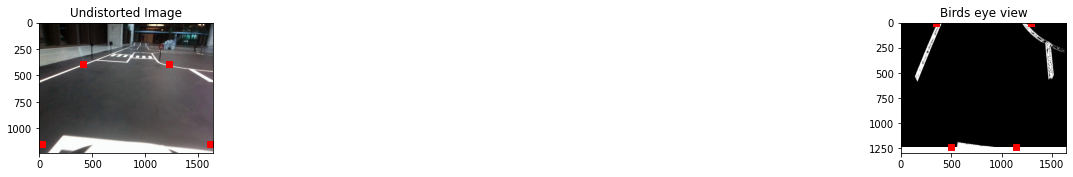

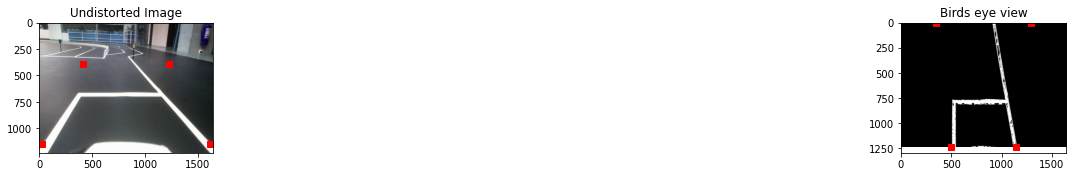

In [115]:
# Read and make a list of test images
images = glob.glob('/home/xrh1/datasets/bosch_dataset/boschyolo_trainval_full/images/train/*.jpg')[:20]
sorted(images, key=lambda x: int(os.path.basename(x).split('_')[-1].replace('.jpg', '') )   )
gidx = 0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    #img = cv2.undistort(img,mtx,dist,None,mtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])

    bot_width = 0.97 # percentage of bottom trapezoidal height
    mid_width = .5 # percentage of mid trapezoidal height
    height_pct = .32 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],
                      [img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.05

    dst = np.float32([[offset,0],
                      [img_size[0]-offset,0],
                      [img_size[0]-offset,img_size[1]],
                      [offset,img_size[1]]])
    
    top_offset = img_size[0]*0.21
    bottom_offset = img_size[0]*0.305
    
    dst = np.float32([[top_offset,0],
                      [img_size[0]-top_offset,0],
                      [img_size[0]-bottom_offset,img_size[1]],
                      [bottom_offset,img_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    plt.subplot(grid[gidx])
    plt.imshow(img, cmap="gray")
    for i in range(4):
        plt.plot(src[i][0],src[i][1],'rs')
    plt.title('Undistorted Image')

    plt.subplot(grid[gidx+1])
    plt.imshow(warped, cmap="gray")
    for i in range(4):
        plt.plot(dst[i][0],dst[i][1],'rs')
    plt.title('Birds eye view')

plt.show()

In [53]:
dst.shape

(480, 640, 3)

In [38]:
matrix_coefficients

array([[512.7447315 ,   0.        , 317.40112573],
       [  0.        , 509.97403498, 233.02928832],
       [  0.        ,   0.        ,   1.        ]])

In [3]:
print('rvecs')
for item in rvecs:
    print(item)
    print()

print('tvecs')
for item in tvecs:
    print(item)
    print()

rvecs
[[-0.53210961]
 [ 0.01548323]
 [ 0.83071245]]

[[-0.63144767]
 [ 0.05828492]
 [ 1.32921126]]

[[-0.47356456]
 [-0.12140508]
 [-0.08142048]]

[[-0.34887329]
 [-0.25549422]
 [-1.28921527]]

[[-0.53187219]
 [-0.04202079]
 [ 0.59344151]]

[[-0.46133328]
 [-0.25421451]
 [-0.35746256]]

[[-0.58439561]
 [-0.07666389]
 [ 0.31456387]]

[[-0.44861942]
 [-0.28739959]
 [-0.55342266]]

[[-0.58511121]
 [ 0.08178464]
 [ 1.24710598]]

[[-0.24373946]
 [-0.2255955 ]
 [-1.65603157]]

[[-0.2102635 ]
 [-0.1905317 ]
 [-1.56896157]]

[[-0.4603393 ]
 [-0.14149988]
 [-0.06732946]]

[[-0.55243273]
 [-0.21909814]
 [-0.28750881]]

[[-0.18748903]
 [-0.13116036]
 [-1.84766118]]

[[-0.44827817]
 [-0.2166804 ]
 [-0.34612916]]

[[-0.18194548]
 [ 0.58870297]
 [ 3.00580652]]

[[-0.2687369 ]
 [-0.3411093 ]
 [-1.76362314]]

[[-0.17863941]
 [-0.24542643]
 [-1.24063705]]

[[-0.47373473]
 [-0.09596612]
 [ 0.03328918]]

[[-0.49205517]
 [-0.29669535]
 [-3.03262998]]

[[-4.01103218e-01]
 [ 1.47099650e-04]
 [-2.33903117e+0

In [24]:
rvec, tvec = rvecs[0], tvecs[0]

In [25]:
rot, jac = cv2.Rodrigues(rvec)

In [26]:
for (img, corners), grid in zip(items, objpoints):
    cv2.drawChessboardCorners(img, (9,6), corners, 1)
    cv2.imshow('img', img)
    cv2.waitKey(500)

In [27]:
import cv2
objectPoints, imagePoints = grid, corners
[success, rvec, tvec] = cv2.solvePnP(objectPoints, imagePoints, matrix_coefficients, distortion_coefficients)
#[...] = cv.solvePnP(..., 'OptionName', optionValue, ...)

In [28]:
import math, numpy as np, cv2
rmat = cv2.Rodrigues(rvec)[0]
cam_pos     = -np.matrix(rmat).T * np.matrix(tvec)
P = np.hstack((rmat,tvec))
euler_angles_radians = -cv2.decomposeProjectionMatrix(P)[6]
euler_angles_degrees = 180 * euler_angles_radians/math.pi


eul    = euler_angles_radians
yaw    = 180*eul[1,0]/math.pi # warn: singularity if camera is facing perfectly upward. Value 0 yaw is given by the Y-axis of the world frame.
pitch  = 180*((eul[0,0]+math.pi/2)*math.cos(eul[1,0]))/math.pi
roll   = 180*( (-(math.pi/2)-eul[0,0])*math.sin(eul[1,0]) + eul[2,0] )/math.pi

In [29]:
R = cv2.Rodrigues(rvec)[0];
R = R.transpose();
pos = -R @ tvec

In [31]:
pos

array([[19.205576  ],
       [ 4.85194582],
       [-7.27201037]])

In [30]:
from math import atan2, asin
roll = atan2(-R[2][1], R[2][2])
pitch = asin(R[2][0])
yaw = atan2(-R[1][0], R[0][0])

print(f'roll:{roll*180/np.pi}\npitch:{pitch*180/np.pi}\nyaw:{yaw*180/np.pi}')

roll:-72.49952058985535
pitch:0.7931653727574447
yaw:84.74012567125213


IndexError: index 20 is out of bounds for GridSpec with size 20

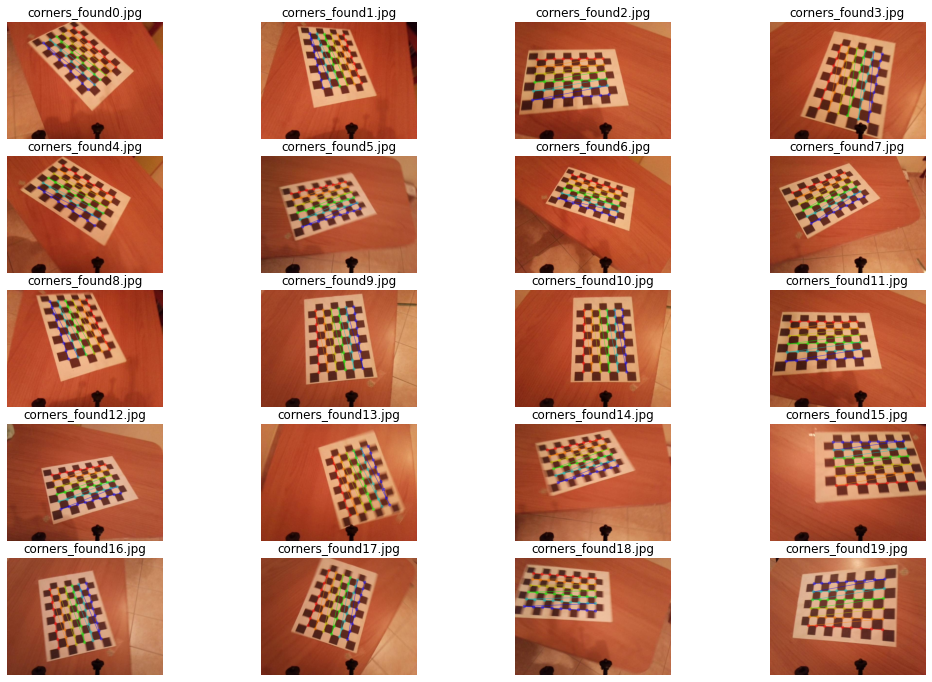

In [12]:
# Calibrate the Camera
# number of inside corners in x & y directions
nx = 9 
ny = 6
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('./calib_images/*.jpg')

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(5,4)
# set the spacing between axes.
grid.update(wspace=0.05, hspace=0.15)  

IDX_CNT = 0

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add to object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'corners_found'+str(IDX_CNT)+'.jpg'
        #cv2.imwrite(write_name,img)
        img_plt = plt.subplot(grid[IDX_CNT])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        #img_plt.set_aspect('equal')
        plt.imshow(img[:,:,::-1])
        plt.title(write_name)
        plt.axis('off')
        IDX_CNT += 1
plt.show()
    #plt.axis('off')

In [9]:
img[:,:,::-1]

array([[[194, 113,  68],
        [195, 114,  69],
        [196, 115,  70],
        ...,
        [218, 137,  94],
        [219, 138,  95],
        [219, 138,  95]],

       [[193, 112,  67],
        [194, 113,  68],
        [196, 115,  70],
        ...,
        [220, 139,  96],
        [219, 138,  95],
        [219, 138,  95]],

       [[193, 112,  67],
        [194, 113,  68],
        [196, 115,  70],
        ...,
        [222, 141,  98],
        [220, 139,  96],
        [219, 138,  95]],

       ...,

       [[156,  83,  30],
        [157,  84,  31],
        [159,  86,  33],
        ...,
        [157,  52,  33],
        [157,  52,  33],
        [157,  52,  33]],

       [[155,  82,  31],
        [157,  84,  33],
        [159,  86,  35],
        ...,
        [156,  51,  32],
        [156,  51,  32],
        [155,  50,  31]],

       [[154,  81,  30],
        [157,  84,  33],
        [159,  86,  35],
        ...,
        [155,  50,  31],
        [155,  50,  31],
        [154,  49,  30]]